This notebook is a modified version of Billing_15min_seaborn_24april25.ipynb. It processes 15-minute interval energy consumption data, calculates customer bills, visualizes the results using Seaborn, and adds a verification step to justify the accuracy of the billing calculations.

Expected Scenario:
Building 1: Surplus (100 kWh). \ Building 2: Small surplus (10 kWh). \ Building 3: Deficit (130 kWh). \Building 4: Deficit (140 kWh).
$$ E_{1\to 3} \approx 48, E_{1\to 4} \approx 52, E_{2\to 3} \approx 5, E_{2\to 4} \approx 5   $$ 


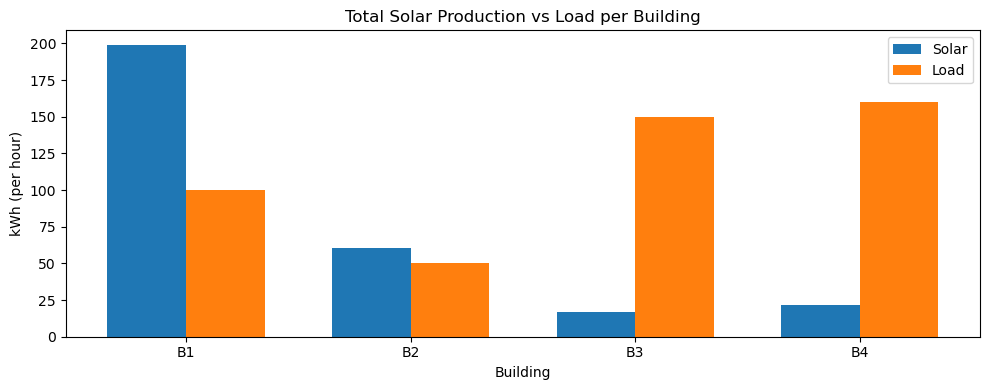

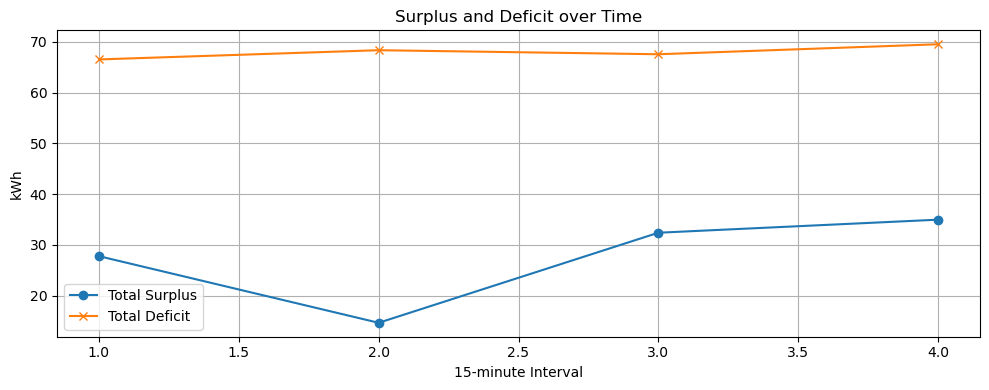

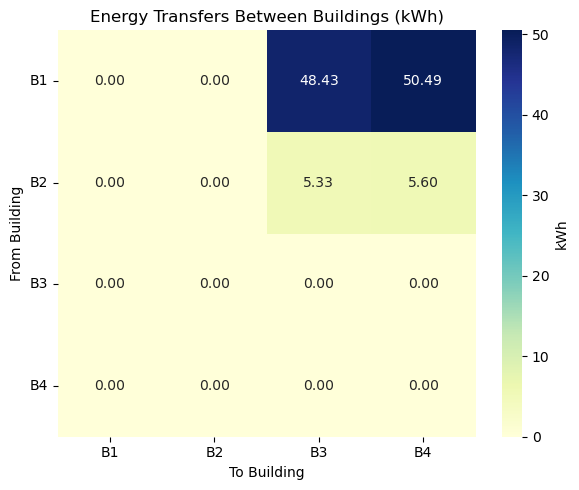

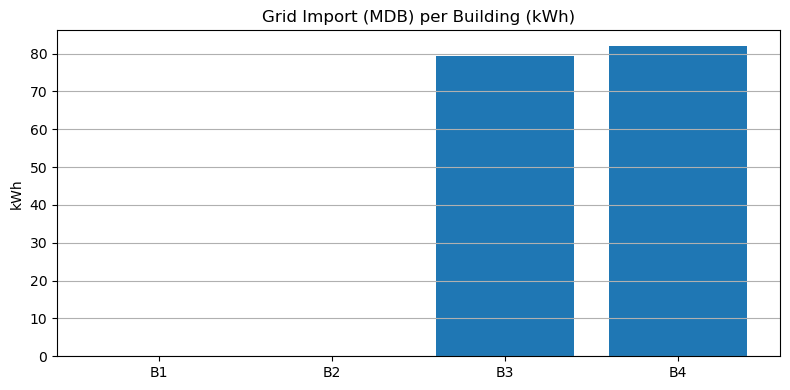


📋 Final Billing Report (Hourly)

🔁 Inter-building Transfers:
Building 3 receives:
  48.434 kWh from Building 1
  5.333 kWh from Building 2
Building 4 receives:
  50.489 kWh from Building 1
  5.596 kWh from Building 2

Building 1 exported a total of 98.923 kWh
Building 2 exported a total of 10.929 kWh

🔌 Grid Import Summary:
Building 1: 0.000 kWh
Building 2: 0.000 kWh
Building 3: 79.256 kWh
Building 4: 82.060 kWh

🌐 Total Grid Import: 161.316 kWh


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
L = np.array([100/4, 50/4, 150/4, 160/4])  # [25, 12.5, 37.5, 40] kWh
S_avg = np.array([200/4, 60/4, 20/4, 20/4])  # [50, 15, 5, 5] kWh
n_buildings = 4
n_intervals = 4
fluctuation = 0.3
np.random.seed(42)

# Simulate solar production
S_intervals = np.array([
    [round(S_avg[i] * (1 + np.random.uniform(-fluctuation, fluctuation)), 3) for i in range(n_buildings)]
    for _ in range(n_intervals)
])

# Initialize
E_total = np.zeros((n_buildings, n_buildings))
M_total = np.zeros(n_buildings)
M5_total = 0
surplus_history = []
deficit_history = []
M_history = []

for t in range(n_intervals):
    S = S_intervals[t]
    surplus_deficit = S - L
    surplus = np.where(surplus_deficit > 0, surplus_deficit, 0)
    deficit = np.where(surplus_deficit < 0, -surplus_deficit, 0)
    total_surplus = np.sum(surplus)
    total_deficit = np.sum(deficit)

    M_pre = S - L
    E = np.zeros((n_buildings, n_buildings))

    # Identify net surplus buildings
    net_surplus = np.sum(S_intervals, axis=0) > L * n_intervals
    eligible_deficit = deficit.copy()
    for i in range(n_buildings):
        if net_surplus[i]:
            eligible_deficit[i] = 0  # Exclude surplus buildings from receiving

    # Allocate surplus to eligible deficits
    total_eligible_deficit = np.sum(eligible_deficit)
    if total_eligible_deficit > 0 and total_surplus > 0:
        deficit_shares = np.divide(eligible_deficit, total_eligible_deficit, 
                                 out=np.zeros_like(eligible_deficit), where=eligible_deficit > 0)
        for i in range(n_buildings):
            if surplus[i] > 0:
                for j in range(n_buildings):
                    if eligible_deficit[j] > 0 and i != j:
                        E[i, j] = round(min(surplus[i] * deficit_shares[j], eligible_deficit[j]), 3)

    M = np.zeros(n_buildings)
    for i in range(n_buildings):
        received = np.sum(E[:, i])
        exported = np.sum(E[i, :])
        M[i] = round(L[i] - S[i] - received + exported, 3)

    if np.sum(M) < 0:
        excess = -np.sum(M)
        surplus_buildings = np.where(M_pre > 0)[0]
        if len(surplus_buildings) > 0:
            reduction = excess / len(surplus_buildings)
            for i in surplus_buildings:
                S[i] -= reduction
                M_pre[i] = S[i] - L[i]
            E = np.zeros((n_buildings, n_buildings))
            surplus = np.where(M_pre > 0, M_pre, 0)
            eligible_deficit = np.where(M_pre < 0, -M_pre, 0)
            for i in range(n_buildings):
                if net_surplus[i]:
                    eligible_deficit[i] = 0
            total_eligible_deficit = np.sum(eligible_deficit)
            if total_eligible_deficit > 0:
                deficit_shares = np.divide(eligible_deficit, total_eligible_deficit, 
                                         out=np.zeros_like(eligible_deficit), where=eligible_deficit > 0)
                for i in range(n_buildings):
                    if surplus[i] > 0:
                        for j in range(n_buildings):
                            if eligible_deficit[j] > 0 and i != j:
                                E[i, j] = round(min(surplus[i] * deficit_shares[j], eligible_deficit[j]), 3)

    for i in range(n_buildings):
        received = np.sum(E[:, i])
        exported = np.sum(E[i, :])
        M[i] = round(L[i] - S[i] - received + exported, 3)
        if net_surplus[i] and M[i] > 0:
            M[i] = 0

    E_total += E
    M_total += M
    M5_total += np.sum(M[M > 0])
    surplus_history.append(total_surplus)
    deficit_history.append(total_deficit)
    M_history.append(M)

# Visualization
plt.figure(figsize=(10, 4))
x = np.arange(n_buildings)
width = 0.35
plt.bar(x - width/2, np.sum(S_intervals, axis=0), width, label='Solar')
plt.bar(x + width/2, L * n_intervals, width, label='Load')
plt.xlabel('Building')
plt.ylabel('kWh (per hour)')
plt.title('Total Solar Production vs Load per Building')
plt.xticks(x, [f"B{i+1}" for i in range(n_buildings)])
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(range(1, n_intervals + 1), surplus_history, marker='o', label='Total Surplus')
plt.plot(range(1, n_intervals + 1), deficit_history, marker='x', label='Total Deficit')
plt.xlabel('15-minute Interval')
plt.ylabel('kWh')
plt.title('Surplus and Deficit over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(E_total, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'kWh'})
plt.title("Energy Transfers Between Buildings (kWh)")
plt.xlabel("To Building")
plt.ylabel("From Building")
plt.xticks(np.arange(n_buildings) + 0.5, [f"B{i+1}" for i in range(n_buildings)])
plt.yticks(np.arange(n_buildings) + 0.5, [f"B{i+1}" for i in range(n_buildings)], rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar([f"B{i+1}" for i in range(n_buildings)], M_total)
plt.title("Grid Import (MDB) per Building (kWh)")
plt.ylabel("kWh")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Final Billing Report
print("\n📋 Final Billing Report (Hourly)\n")
print("🔁 Inter-building Transfers:")
for j in range(n_buildings):
    incoming = np.sum(E_total[:, j])
    if incoming > 0:
        print(f"Building {j+1} receives:")
        for i in range(n_buildings):
            if E_total[i, j] > 0:
                print(f"  {E_total[i, j]:.3f} kWh from Building {i+1}")
print()
for i in range(n_buildings):
    exported = np.sum(E_total[i, :])
    if exported > 0:
        print(f"Building {i+1} exported a total of {exported:.3f} kWh")
print("\n🔌 Grid Import Summary:")
for i in range(n_buildings):
    print(f"Building {i+1}: {M_total[i]:.3f} kWh")
print(f"\n🌐 Total Grid Import: {M5_total:.3f} kWh")